<div style="background-color: #d1a8ed; color: black; border: 5px solid #9038b5; padding: 10px;">
  <h1>Fashion Image Generator</h1>
  <ul>
    <li>Data comes from the 
      <a href="https://www.kaggle.com/datasets/zalando-research/fashionmnist/data" target="_blank" style="color: blue;">Fashion MNIST Dataset</a>.
    </li>
    <li>Here are the 
      <a href="https://github.com/USFCA-MSDS/MSDS-631-GenAI" target="_blank" style="color: blue;">project instructions</a>.
    </li>
    </li>
  </ul>
</div>

---

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Imports & Functions</h1>
</div>

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import Subset, DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import gzip
import os

TEST_CODE = False

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Data Preprocessing</h1>
</div>

# Load & Label

In [2]:
df = pd.read_csv('fashion-mnist_train.csv') 
labels = df.iloc[:, 0].values
images = df.iloc[:, 1:].values.astype(np.uint8).reshape(-1, 28, 28)

print(images.dtype)       
print(images.min(), images.max())
print(f"✅ Loaded {len(images)} images and {len(labels)} labels from CSV")

uint8
0 255
✅ Loaded 60000 images and 60000 labels from CSV


# View

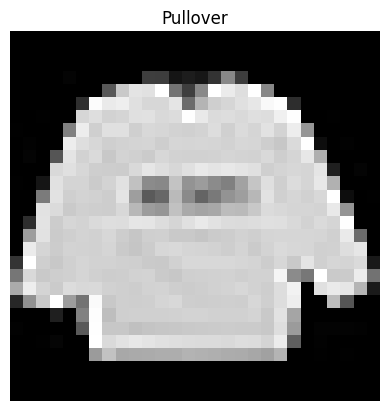

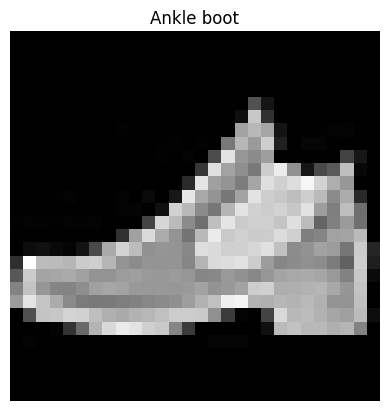

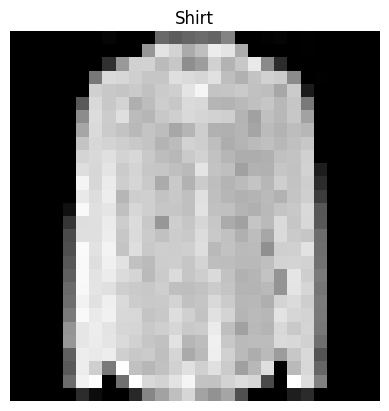

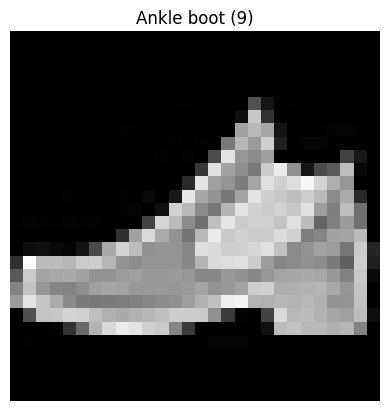

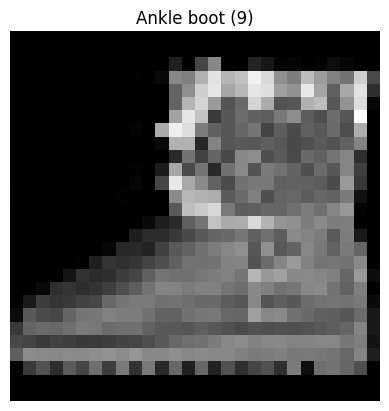

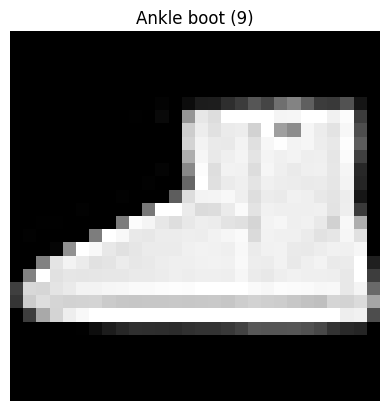

In [3]:
def view_image_by_num(index):
    """
    Display an image and its label from a given index.

    Parameters
    ----------
        - index (int): Index of the image in the dataset.

    Returns
    -------
        - None: Displays the image with its string label as title.
    """
    label_map = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }

    image = Image.fromarray(images[index], mode='L').convert("RGB")
    label = labels[index]
    label_str = label_map.get(label, f"Unknown ({label})")

    plt.imshow(image)
    plt.axis('off')
    plt.title(label_str)
    plt.show()


def view_image_by_label(label, n=3):
    """
    Displays up to n images that have the given label.

    Parameters
    ----------
        - label (int or str): Class label index (0–9) or name (e.g. 'Shirt').
        - n (int): Number of images to display (default: 3).
    
    Returns
    -------
        - None: Displays images using matplotlib.
    """
    label_map = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }

    if isinstance(label, str):
        label = label.lower().strip()
        reverse_map = {v.lower(): k for k, v in label_map.items()}
        if label not in reverse_map:
            print(f"Invalid label name '{label}'")
            return
        label = reverse_map[label]

    count = 0
    for i in range(len(labels)):
        if labels[i] == label:
            image = Image.fromarray(images[i], mode='L').convert("RGB")
            plt.imshow(image)
            plt.title(f"{label_map[label]} ({label})")
            plt.axis('off')
            plt.show()
            count += 1
            if count >= n:
                break


for i in range(3):
    view_image_by_num(i)

view_image_by_label("Ankle boot", n=3)

# Transform

In [4]:
class FashionMNISTFromCSV(Dataset):
    """
    A custom PyTorch Dataset for Fashion-MNIST loaded from a CSV file.

    Each image is represented as a 28x28 grayscale array and associated with a label (0–9).
    This class wraps images and labels loaded into memory, and supports optional transforms.

    Parameters
    ----------
        - images (np.ndarray): A numpy array of shape (N, 28, 28) containing grayscale image data.
        - labels (np.ndarray): A numpy array of shape (N,) containing integer labels (0–9).
        - transform (callable): Optional torchvision transform to apply to each image (e.g., ToTensor, Resize, Normalize).

    Returns
    -------
        - image (PIL.Image or torch.Tensor): The transformed image sample.
        - label (int): The integer label corresponding to the image.
    """
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx], mode='L').convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

dataset = FashionMNISTFromCSV(images, labels, transform=transform)

if TEST_CODE==True: 
    indices = list(range(0, 10))  # first 10 images
    subset_dataset = Subset(dataset, indices)
    dataloader = DataLoader(subset_dataset, batch_size=4, shuffle=True)
else: 
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for images, labels in dataloader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels: {labels}")
    break

Batch images shape: torch.Size([4, 3, 32, 32])
Batch labels: tensor([7, 5, 4, 8])


<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Model Implementation</h1>
</div>

In [5]:
class VAE(nn.Module): 
    """ 
    Base Variational Autoencoder (VAE) class.
    
    Encodes input into a latent distribution (mean and log variance),
    samples from it, and reconstructs the input from the sampled latent vector.
    """

    def __init__(self, input_dim, hidden_dim, z_dim, projected_label_dim): 
        """ 
        Initialize encoder and decoder.

        Parameters
        ----------
            - input_dim (int): Dimensionality of input features.
            - hidden_dim (int): Size of hidden layer.
            - z_dim (int): Dimensionality of latent space.

        """
        super(VAE, self).__init__() 

        # Maps input to a latent Gaussian (mean + log variance)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, z_dim*2)  # to get both mean and log_var
        )

        # Maps latent variable z back to reconstructed input
        self.decoder = nn.Sequential(
            nn.Linear(z_dim + projected_label_dim, hidden_dim),
            nn.ReLU(), 
            nn.Linear(hidden_dim, input_dim), 
            nn.Sigmoid() 
        )
        self.z_dim = z_dim 
    
    def reparameterize(self, mu, log_var): 
        """ 
        Perform the reparameterization trick (convert mean/log_var into a sampled z).

        Parameters
        ----------
            - mu (Tensor): Mean of latent distribution.
            - log_var (Tensor): Log variance of latent distribution.

        Returns
        -------
            - z (Tensor): Sampled latent vector.
        """
        std = torch.exp(0.5 * log_var) # Convert log_var to standard deviation
        eps = torch.randn_like(std)    # Sample from N(0, 1) with same shape
        return mu + eps*std
    
    def forward(self, x): 
        """ 
        Placeholder forward method. Should be implemented in subclasses.

        Parameters
        ----------
            - x (Tensor): Input tensor.
        """
        pass  


class ConditionalVAE(VAE):
    """ 
    Conditional Variational Autoencoder.

    Extends VAE by conditioning latent space on class labels.
    """

    def __init__(self, input_dim, hidden_dim, z_dim, num_classes, projected_label_dim):
        """ 
        Initialize ConditionalVAE.

        Parameters
        ----------
            - input_dim (int): Dimensionality of input features.
            - hidden_dim (int): Size of hidden layer.
            - z_dim (int): Dimensionality of latent space.
            - num_classes (int): Number of class labels.
        """
        super(ConditionalVAE, self).__init__(input_dim, hidden_dim, z_dim, projected_label_dim)
        self.label_projector = nn.Sequential(
            nn.Linear(num_classes, projected_label_dim),
            nn.ReLU(),
        )

    def condition_on_label(self, z, y):
        """ 
        Inject label information into latent vector.

        Parameters
        ----------
            - z (Tensor): Latent vector.
            - y (Tensor): One-hot encoded class labels.

        Returns
        -------
            - z_cond (Tensor): Label-conditioned latent vector.
        """
        projected_label = self.label_projector(y.float())
        return torch.cat((z, projected_label), dim=1)

    def forward(self, x, y):
        """ 
        Forward pass for ConditionalVAE.

        Parameters
        ----------
            - x (Tensor): Input features.
            - y (Tensor): One-hot encoded class labels.

        Returns
        -------
            - encoded (Tensor): Raw encoder output (mu and log_var).
            - decoded (Tensor): Reconstructed input.
            - mu (Tensor): Mean of latent distribution.
            - log_var (Tensor): Log variance of latent distribution.
        """
        encoded = self.encoder(x)                                   # Pass the input through the encoder
        mu, log_var = torch.chunk(encoded, 2, dim=1)                # Compute the mean and log variance vectors
        z = self.reparameterize(mu, log_var)                        # Reparameterize the latent variable
        decoded = self.decoder(self.condition_on_label(z, y))       # Pass the latent variable through the decoder

        return encoded, decoded, mu, log_var

    def sample(self, num_samples, y):
        """ 
        Generate samples from the latent space conditioned on labels.

        Parameters
        ----------
            - num_samples (int): Number of samples to generate.
            - y (Tensor): One-hot encoded class labels.

        Returns
        -------
            - samples (Tensor): Generated samples.
        """
        with torch.no_grad():
            z = torch.randn(num_samples, self.z_dim).to(y.device)    # Generate random noise
            samples = self.decoder(self.condition_on_label(z, y))    # Pass the noise through the decoder to generate samples
            
        return samples                            

In [6]:
def train_conditionalVAE(model_num, 
                         input_dim, 
                         hidden_dim, 
                         z_dim, 
                         num_classes,
                         projected_label_dim,  
                         optimizer_name, 
                         lr, 
                         num_epochs=100, 
                         batch_size=64):

    """ 
    Trains a Conditional Variational Autoencoder (ConditionalVAE) with given hyperparameters.

    Parameters
    ----------
        - model_num (int): Model number for saving the trained model checkpoint.
        - input_dim (int): Flattened input dimension (e.g. 3×32×32 = 3072).
        - hidden_dim (int): Size of hidden layer in encoder/decoder.
        - z_dim (int): Dimensionality of latent space.
        - num_classes (int): Number of class labels.
        - optimizer_name (str): Optimizer to use ('adam', 'sgd', etc.).
        - lr (float): Learning rate.
        - num_epochs (int, optional): Number of training epochs (default=100).
        - batch_size (int, optional): Batch size for training (default=64).

    Returns
    -------
        - recon_losses (list): Reconstruction loss per epoch.
        - kl_losses (list): KL divergence loss per epoch.
        - total_losses (list): Total loss per epoch.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    vae = ConditionalVAE(input_dim=input_dim,
                         hidden_dim=hidden_dim,
                         z_dim=z_dim,
                         num_classes=num_classes,
                         projected_label_dim=projected_label_dim).to(device)

    # Choose optimizer
    if optimizer_name.lower() == "adam":
        optimizer = optim.Adam(vae.parameters(), lr=lr)
    elif optimizer_name.lower() == "sgd":
        optimizer = optim.SGD(vae.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # Rebuild dataloader with new batch size
    if TEST_CODE:
        indices = list(range(0, 10))
        subset_dataset = Subset(dataset, indices)
        dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.BCELoss(reduction='sum')
    recon_losses, kl_losses, total_losses = [], [], []

    print('===========================================================')
    print(f"Model {model_num} (z_dim={z_dim}, batch_size={batch_size})")
    print('===========================================================\n')
    
    for epoch in tqdm(range(num_epochs)):
        vae.train()
        running_recon_loss, running_kl_loss = 0.0, 0.0

        for images, labels in dataloader:
            images = images.view(images.size(0), -1).to(device)  # Flatten
            labels = nn.functional.one_hot(labels, num_classes=num_classes).float().to(device)

            optimizer.zero_grad()
            _, recon_images, mu, logvar = vae(images, labels)

            recon_loss = criterion(recon_images, images)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss

            loss.backward()
            optimizer.step()

            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()

        recon_losses.append(running_recon_loss / len(dataset))
        kl_losses.append(running_kl_loss / len(dataset))
        total_losses.append((running_recon_loss + running_kl_loss) / len(dataset))

        if epoch % 25 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch}\n-------")
            print(f"Recon: {recon_losses[-1]:.6f} KL: {kl_losses[-1]:.6f} Total: {total_losses[-1]:.6f}\n")

    os.makedirs("models", exist_ok=True)
    torch.save({
        'model_state_dict': vae.state_dict(),
        'z_dim': z_dim,
        'hidden_dim': hidden_dim,
        'num_classes': num_classes,
        'projected_label_dim': projected_label_dim  # <-- add this
    }, f"condVAEmodels/condVAEmodel{model_num}.pt")

    print(f"Saved as condVAEmodels/condVAEmodel{model_num}.pt\n")

    return recon_losses, kl_losses, total_losses

<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Methods</h1>
</div>

In [7]:
latent_dims = [8, 32, 500]
batch_sizes = [32, 64]
all_losses = []

# Fixed values
hidden_dim = 256
optimizer_name = 'adam'
lr = 1e-3
num_epochs = 50
input_dim = 3 * 32 * 32
num_classes = 10
batch_size = 64

model_num = 1
for z_dim in latent_dims:
    for batch_size in batch_sizes:
        projected_label_dim = z_dim  # match label embedding to z_dim

        recon_losses, kl_losses, total_losses = train_conditionalVAE(
            model_num=model_num,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            z_dim=z_dim,
            num_classes=num_classes,
            projected_label_dim=projected_label_dim,
            optimizer_name=optimizer_name,
            lr=lr,
            num_epochs=num_epochs,
            batch_size=batch_size
        )
        
        all_losses.append({
            'model_num': model_num,
            'z_dim': z_dim,
            'batch_size': batch_size, 
            'recon_losses': recon_losses,
            'kl_losses': kl_losses,
            'total_losses': total_losses
        })
        
        model_num += 1

Model 1 (z_dim=8, batch_size=32)



  2%|▏         | 1/50 [00:11<09:06, 11.16s/it]

Epoch 0
-------
Recon: 986.161555 KL: 23.731029 Total: 1009.892584



 52%|█████▏    | 26/50 [04:06<03:57,  9.90s/it]

Epoch 25
-------
Recon: 916.093055 KL: 19.040206 Total: 935.133261



100%|██████████| 50/50 [08:02<00:00,  9.66s/it]


Epoch 49
-------
Recon: 914.191126 KL: 18.914917 Total: 933.106043

Saved as condVAEmodels/condVAEmodel1.pt

Model 2 (z_dim=8, batch_size=64)



  2%|▏         | 1/50 [00:06<05:22,  6.58s/it]

Epoch 0
-------
Recon: 1009.716199 KL: 25.499611 Total: 1035.215810



 52%|█████▏    | 26/50 [03:13<02:55,  7.33s/it]

Epoch 25
-------
Recon: 916.179315 KL: 19.494405 Total: 935.673720



100%|██████████| 50/50 [06:23<00:00,  7.67s/it]


Epoch 49
-------
Recon: 913.654409 KL: 19.251939 Total: 932.906348

Saved as condVAEmodels/condVAEmodel2.pt

Model 3 (z_dim=32, batch_size=32)



  2%|▏         | 1/50 [00:11<09:45, 11.95s/it]

Epoch 0
-------
Recon: 989.098931 KL: 32.426566 Total: 1021.525497



 52%|█████▏    | 26/50 [05:09<04:55, 12.32s/it]

Epoch 25
-------
Recon: 900.257396 KL: 27.394241 Total: 927.651636



100%|██████████| 50/50 [09:53<00:00, 11.86s/it]


Epoch 49
-------
Recon: 898.490343 KL: 27.184007 Total: 925.674351

Saved as condVAEmodels/condVAEmodel3.pt

Model 4 (z_dim=32, batch_size=64)



  2%|▏         | 1/50 [00:07<06:17,  7.71s/it]

Epoch 0
-------
Recon: 1026.320000 KL: 33.080751 Total: 1059.400751



 52%|█████▏    | 26/50 [03:29<03:22,  8.42s/it]

Epoch 25
-------
Recon: 899.487872 KL: 27.849059 Total: 927.336931



100%|██████████| 50/50 [06:38<00:00,  7.98s/it]


Epoch 49
-------
Recon: 897.426907 KL: 27.600704 Total: 925.027611

Saved as condVAEmodels/condVAEmodel4.pt

Model 5 (z_dim=500, batch_size=32)



  2%|▏         | 1/50 [00:14<12:10, 14.90s/it]

Epoch 0
-------
Recon: 1051.466513 KL: 24.525688 Total: 1075.992201



 52%|█████▏    | 26/50 [06:27<06:00, 15.03s/it]

Epoch 25
-------
Recon: 937.222118 KL: 18.756953 Total: 955.979071



100%|██████████| 50/50 [12:28<00:00, 14.97s/it]


Epoch 49
-------
Recon: 935.045000 KL: 18.771545 Total: 953.816545

Saved as condVAEmodels/condVAEmodel5.pt

Model 6 (z_dim=500, batch_size=64)



  2%|▏         | 1/50 [00:09<07:37,  9.34s/it]

Epoch 0
-------
Recon: 1072.572583 KL: 24.295877 Total: 1096.868461



 52%|█████▏    | 26/50 [04:02<03:42,  9.29s/it]

Epoch 25
-------
Recon: 928.204937 KL: 19.420002 Total: 947.624940



100%|██████████| 50/50 [07:30<00:00,  9.01s/it]

Epoch 49
-------
Recon: 925.523287 KL: 19.675096 Total: 945.198382

Saved as condVAEmodels/condVAEmodel6.pt



<div class="alert alert-block alert-warning"  
     style="background-color: #d1a8ed; color: black; border: 5px solid#9038b5; padding: 10px;">  
  <h1>Experiments & Results</h1>
</div>

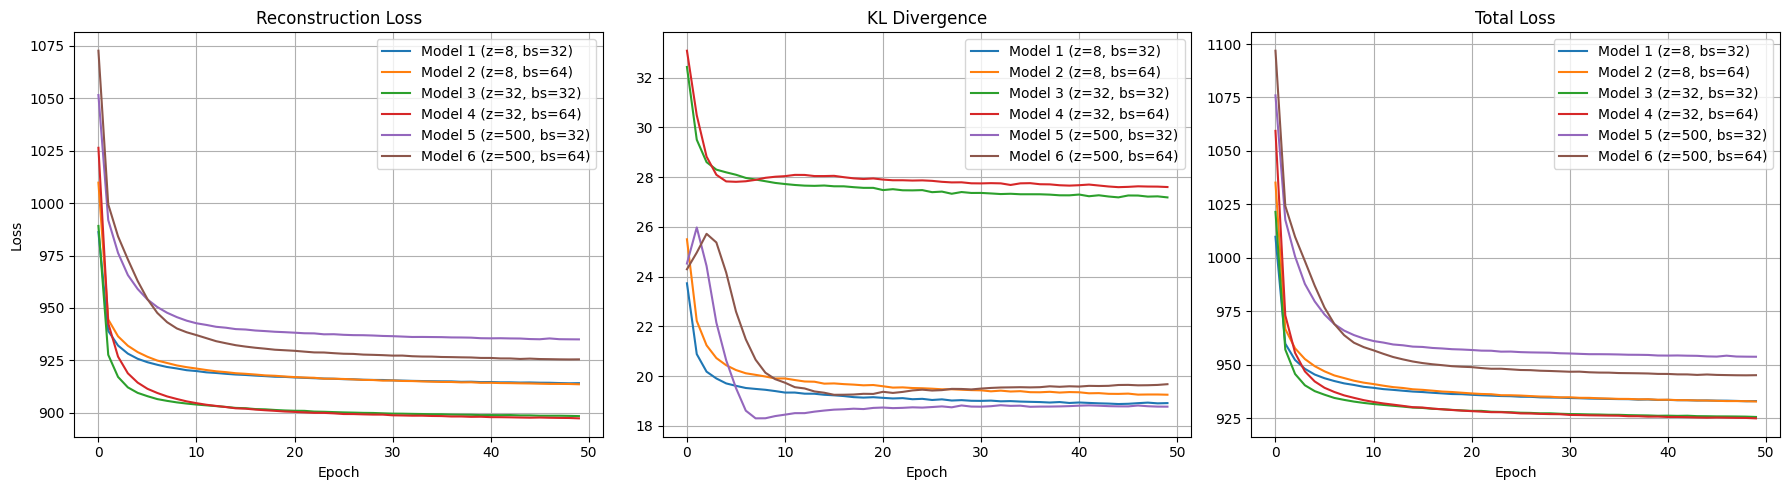

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

for result in all_losses:
    model_num = result['model_num']
    z_dim = result['z_dim']
    batch_size = result['batch_size']
    recon_losses = result['recon_losses']
    kl_losses = result['kl_losses']
    total_losses = result['total_losses']
    
    label = f"Model {model_num} (z={z_dim}, bs={batch_size})"
    axs[0].plot(recon_losses, label=label)
    axs[1].plot(kl_losses, label=label)
    axs[2].plot(total_losses, label=label)

axs[0].set_title('Reconstruction Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('KL Divergence')
axs[1].set_xlabel('Epoch')
axs[1].legend()
axs[1].grid(True)

axs[2].set_title('Total Loss')
axs[2].set_xlabel('Epoch')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [9]:
def load_model_and_generate(model_num, label_name):
    """ 
    Loads a trained Conditional VAE model and generates a grid of new images conditioned on a class name.

    Parameters
    ----------
        - model_num (int): Model number corresponding to saved model (e.g., 1–6).
        - label_name (str): Human-readable class label (e.g. 'shirt', 'sneaker').

    Returns
    -------
        - None: Displays a grid of generated images using matplotlib.
    """
    
    label2index = {
        't-shirt/top': 0,
        'trouser': 1,
        'pullover': 2,
        'dress': 3,
        'coat': 4,
        'sandal': 5,
        'shirt': 6,
        'sneaker': 7,
        'bag': 8,
        'ankle boot': 9
    }
    label_name = label_name.lower().strip()      # Normalize label string to lowercase and strip spaces
    label_aliases = {                            # Simple fuzzy matching
        'tshirt': 't-shirt/top',
        't-shirt': 't-shirt/top',
        'top': 't-shirt/top',
        'pants': 'trouser',
        'boots': 'ankle boot',
    }

    if label_name in label_aliases:
        label_name = label_aliases[label_name]

    if label_name not in label2index:
        raise ValueError(f"Invalid label name '{label_name}'. Valid options: {list(label2index.keys())}")

    label = label2index[label_name]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = 3 * 32 * 32  

    # Load checkpoint and model config
    checkpoint = torch.load(f"condVAEmodels/condVAEmodel{model_num}.pt", map_location=device)
    z_dim = checkpoint['z_dim']
    hidden_dim = checkpoint['hidden_dim']
    num_classes = checkpoint['num_classes']
    projected_label_dim = checkpoint['projected_label_dim']

    # Initialize and load the model
    vae = ConditionalVAE(input_dim=input_dim,
                         hidden_dim=hidden_dim,
                         z_dim=z_dim,
                         num_classes=num_classes,
                         projected_label_dim=projected_label_dim).to(device)

    vae.load_state_dict(checkpoint['model_state_dict'])
    vae.eval()

    # Generate samples
    with torch.no_grad():
        z = torch.randn(64, z_dim).to(device)
        y = torch.full((64,), label, dtype=torch.long, device=device)
        y_onehot = F.one_hot(y, num_classes=num_classes).float()

        samples = vae.sample(num_samples=64, y=y_onehot).cpu()
        samples = samples.view(-1, 3, 32, 32)

        # Plot results
        grid = make_grid(samples, nrow=8, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.title(f'Generated {label_name.title()} from Model {model_num}')
        plt.show()

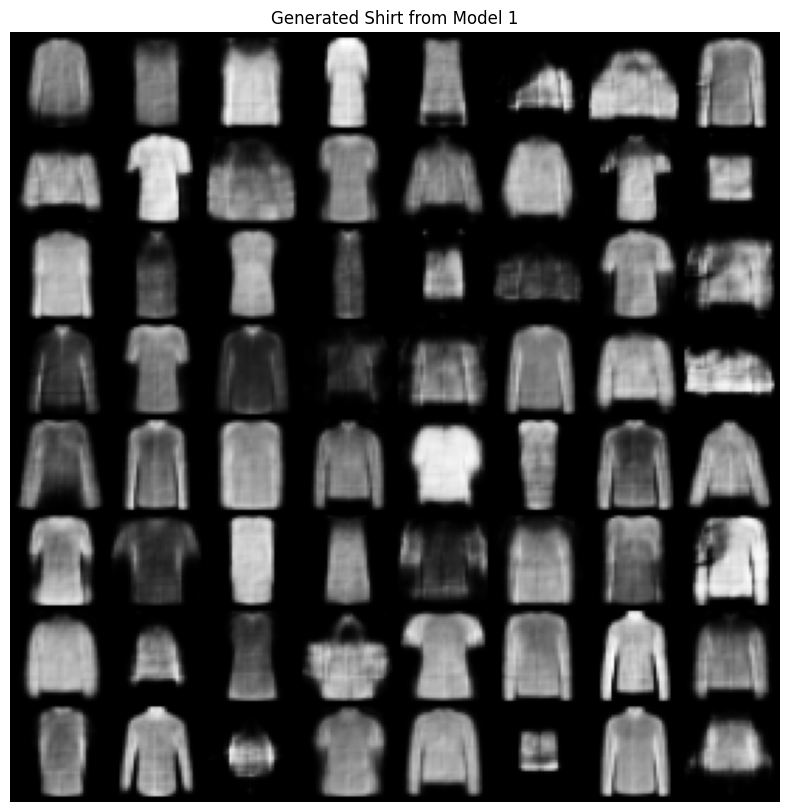

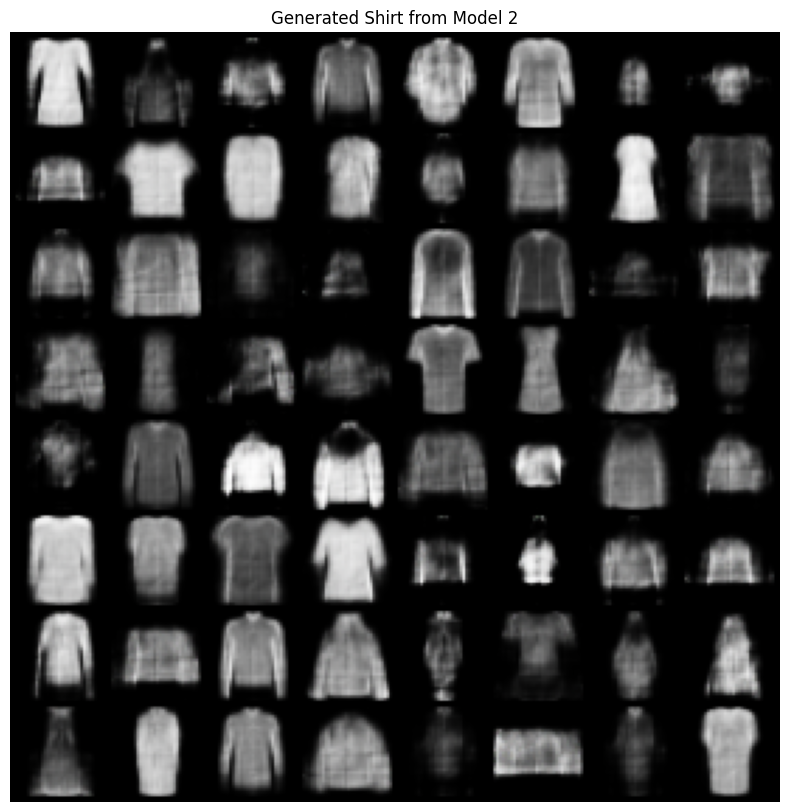

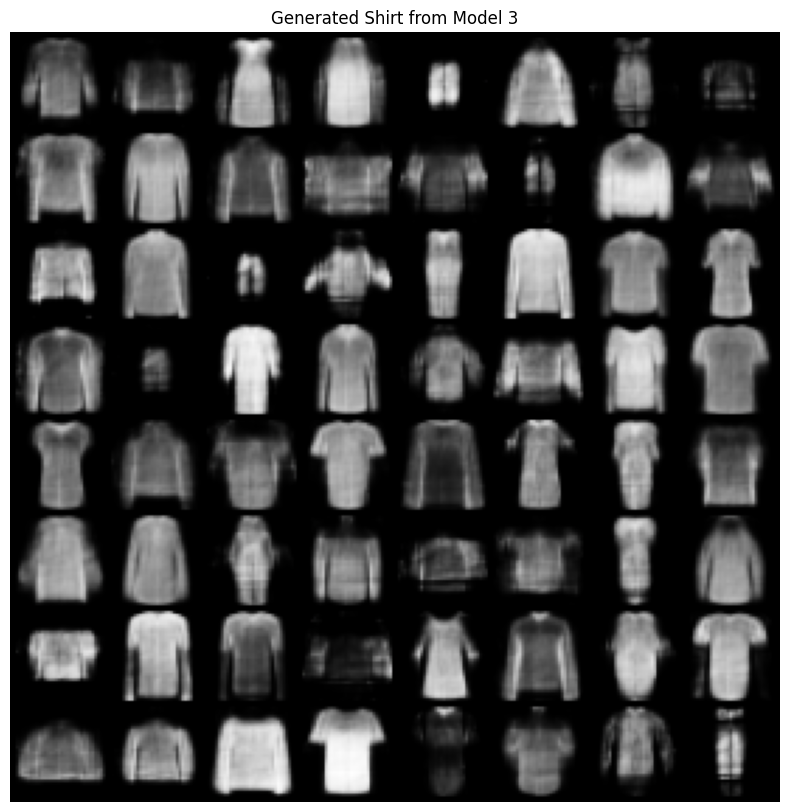

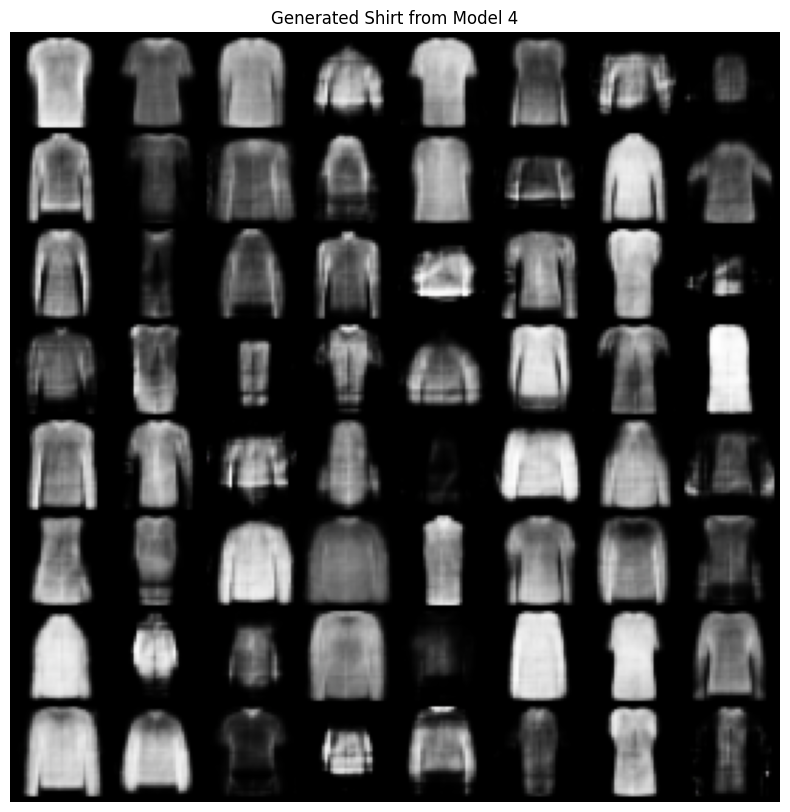

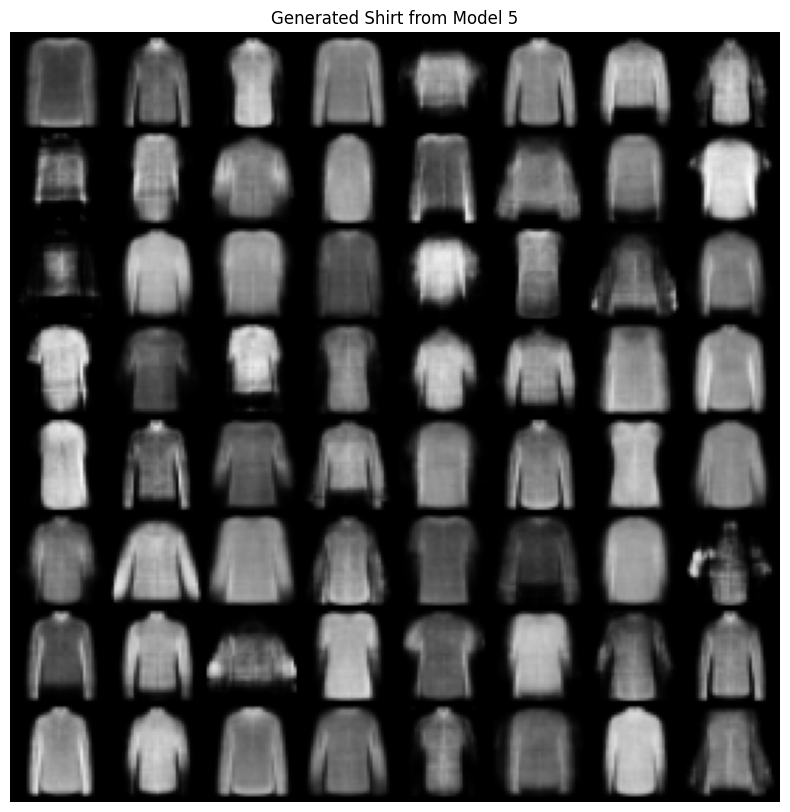

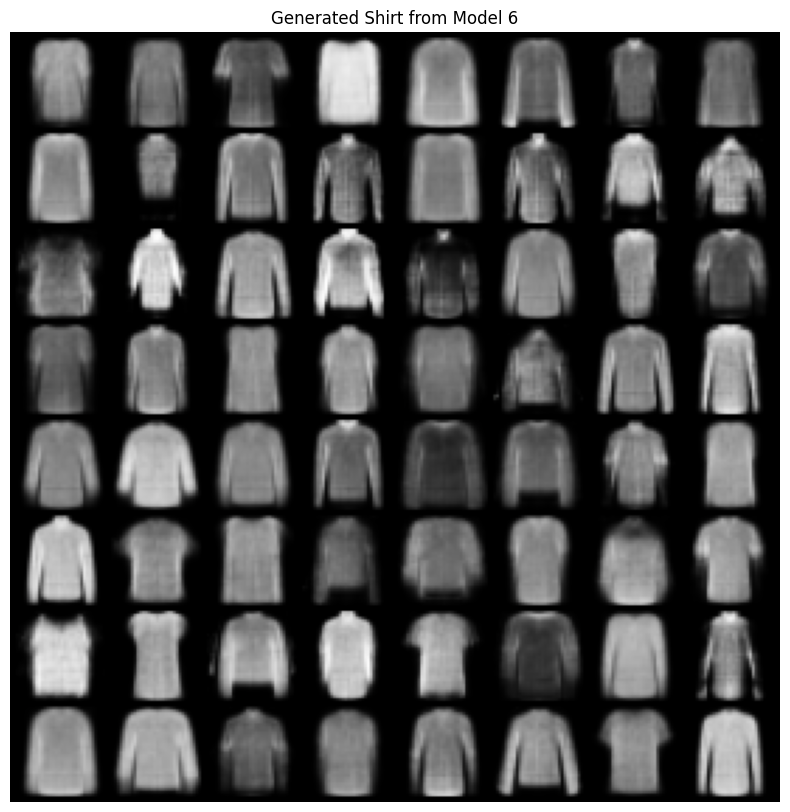

In [10]:
for i in range(1, 7):
    load_model_and_generate(model_num=i, label_name='shirt')